# Testing the constant-time case


## Import useful packages

In [14]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import boto3
import io


## Define functions to load the data


#### This code gets list of keys (ie files) in S3 bucket
(Should consider moving this into a helper file.)

In [3]:
def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                break

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    obj_list=[]
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        obj_list.append(obj["Key"])
    return(obj_list)


### Key image read-in functions: load_image and build_input

In [40]:
def load_image(s3_client,bucket_name,file_name, dim=(224,224)):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_name:  file to convert to image

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    #image = cv2.imread(image_path, 0)
    file_stream = io.BytesIO()
    s3.download_fileobj(bucket_name,s3_file,file_stream)
    nparr = np.frombuffer(file_stream.getvalue(), np.uint8)
    image=cv2.imdecode(nparr,1)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [41]:
def build_input(s3_client,bucket_name,file_list):
  """
  Loads all of the images into a single numpy array.
  Assumes that there are 101 equally-spaced images
  spanning lattitudes from 35N to 45N.  

  Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_list:  list of files in bucket
  Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.
    
    y:  A 1-dimensional numpy array of target lattitudes.
    """
  X = []
  for file in file_list:
    if file[-4:] == '.png':
      image = load_image(s3_client,bucket_name,file_name)
      X.append(image)
  return (np.array(X) / 255)

In [47]:
def build_labels(file_list):
  y = []
  for file in file_list:
    if file[-4:] == '.png':
      file_split = file.split('+')
      lat = float(file_split[0])
      long = float(file_split[1])
      y.append((lat, long))
  return np.array(y)

#### Test load_image on one image manually

(224, 224, 3)


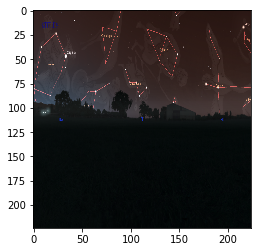

In [38]:
bucket_name='w251-final-project'
file_name='frame_000.png'
s3 = boto3.client('s3')
sample_image = load_image(s3,bucket_name,file_name)
plt.imshow(sample_image)
print(sample_image.shape)

## Prepare the data

### Load the images

In [50]:
bucket_name='w251-final-project'
file_list=get_matching_s3_keys(bucket_name)
s3 = boto3.client('s3')

#get images
print('about to call build_input on',len(file_list),' files')
X = build_input(s3,bucket_name,file_list)
print ('shape of image array:', X.shape)

#get labels
print ('building labels')
y = build_labels(file_list)
print ('shape of label list:', y.shape)

about to call build_input on 1  files
shape of image array: (1, 224, 224, 3)
building labels


ValueError: could not convert string to float: 'frame_000.png'


Standardize the values

In [ ]:
y[:,0] = scale(y[:,0])
y[:,1] = scale(y[:,1])

In [ ]:
print(y[:,0].mean(), y[:,0].std())
print(y[:,1].mean(), y[:,1].std())

### Split into test and training sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

## The model

We can probably prune this back a bit.  This is simply a DNN with single layer output suitable for regression.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

In [ ]:
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

`callbacks` can be used to tell the model when to stop training.  In this case, I'm having it stop if the mean squared error hasn't improved for 20 epochs.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=30)

Fit the model.

In [ ]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
                    verbose=2, epochs=1000, callbacks=[callback])

### Evaluate model performance

In [ ]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [ ]:
y_hat = model.predict(X_val)

In [ ]:
plt.scatter(y_val[:,0], y_hat[:,0])
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

In [ ]:
plt.scatter(y_val[:,1], y_hat[:,1])
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()